In [1]:
%matplotlib inline
from dfply import *
import pandas as pd 
import numpy as np
import pandas_profiling
import seaborn as sns
from plotnine import *
from statsmodels.compat import lzip
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

In [2]:
houses_areas = pd.read_csv("../clean_data/houses_areas.csv")

In [3]:
houses_areas.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000,20337.000000
mean,-119.574855,35.629232,28.646752,2652.305846,543.753012,1424.393224,502.515514,3.872290,208265.268181
std,2.004263,2.137074,12.569763,2175.046819,424.319459,1095.319032,380.347356,1.897259,115229.632797
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.810000,33.930000,18.000000,1463.000000,299.000000,791.000000,282.000000,2.562500,121400.000000
50%,-118.490000,34.250000,29.000000,2143.000000,438.000000,1169.000000,412.000000,3.536400,181300.000000
75%,-118.010000,37.720000,37.000000,3163.000000,652.000000,1726.000000,607.000000,4.750000,266200.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


Here we can see some general stadistics about the data_set. But first let's transform the categorical variables in dummy varibles so we can use then 

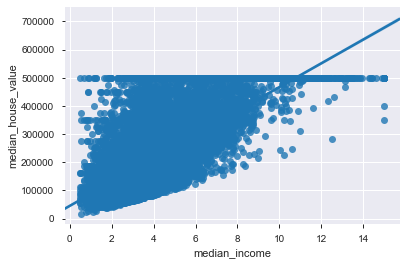

In [4]:
sns.regplot(x = "median_income", y = "median_house_value", data = houses_areas)

Here we can't indentify a clear linear patron but most of the time the price of the house grow up when the income grow up. It is a funny case in houses with a value close to 500001 because areas with very different median income have houses with this value. 
Now let's check the behavior of median_house_value with median_income and the proximity to the ocean.

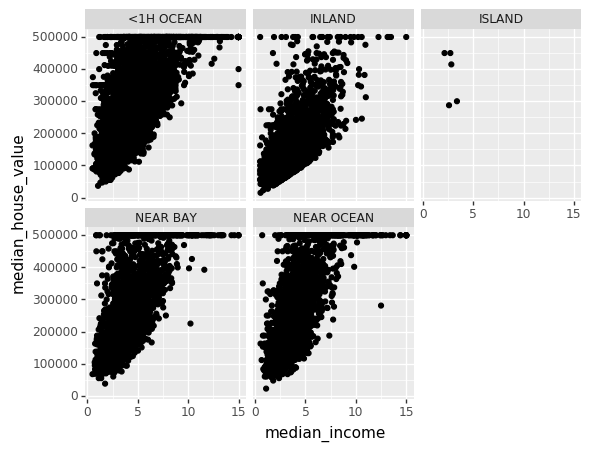

<ggplot: (8764419453505)>


In [5]:
print(ggplot(houses_areas)
     + aes(x = "median_income", y = "median_house_value")
     + geom_point()
     + facet_wrap("~ocean_proximity"))

/usr/local/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 46'. Pick better value with 'binwidth'.


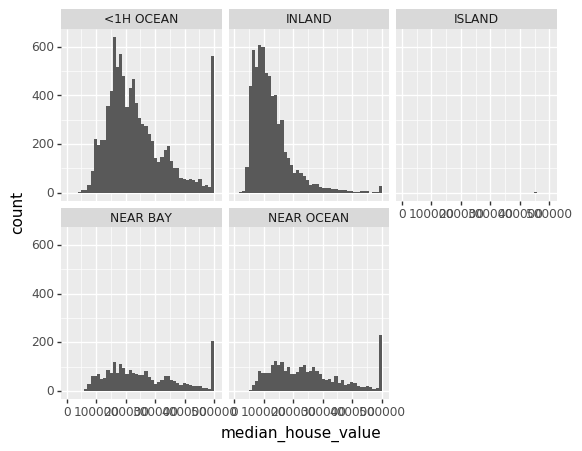

<ggplot: (8764426720925)>


In [6]:
print(ggplot(houses_areas)
     + aes(x = "median_house_value")
     + geom_histogram()
     + facet_wrap("~ocean_proximity"))

We can see in those graphs that when the price of the house is 500001 it is the higher value and it is present in every median income and ocean_proximity. It makes that all the graphs become very sweken to the right. I will try a model withouth that value and withit to see how that works 

In [7]:
houses_areas_1 = houses_areas >> mask(X.median_house_value < 500001)

Here we will create the dummies varuables for run our linear model with the categorical variables

In [8]:
pandas_profiling.ProfileReport(houses_areas)

In [9]:
pandas_profiling.ProfileReport(houses_areas_1)

Let's build a model with the variable that looks more correlative, house_median_income 

In [10]:
houses_areas_model = ols("median_house_value ~ median_income", data = houses_areas).fit()
print(houses_areas_model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                 1.902e+04
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:30   Log-Likelihood:            -2.5916e+05
No. Observations:               20337   AIC:                         5.183e+05
Df Residuals:                   20335   BIC:                         5.183e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.477e+04   1320.191     33.914

So with only the median_income, the R-squared is 0.483 it isn't great but is ok. The P value is lower than 0.05 so actually it is enough evidence for continue with this variable inside the model. Now let's check how is the stadistic behavior of the residuals 

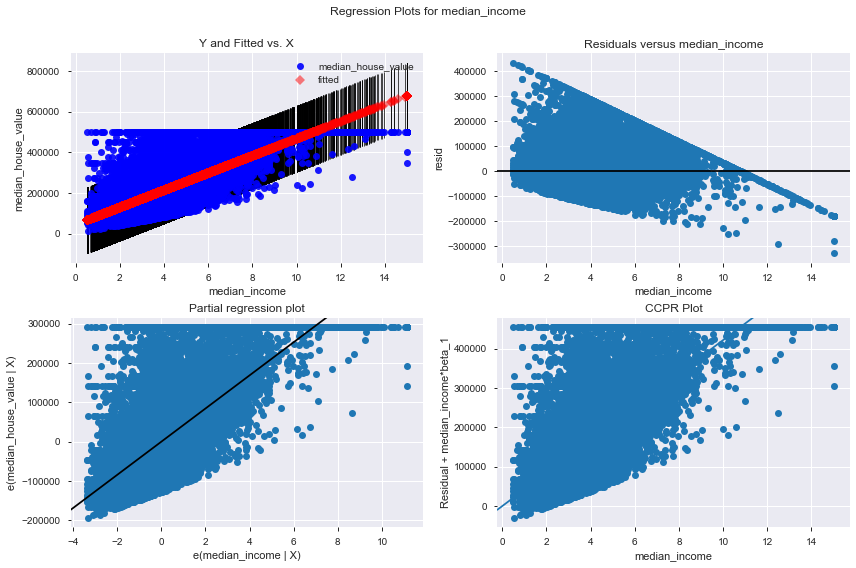

In [11]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(houses_areas_model, "median_income", fig=fig)

To be honest the residuals doesn't look particulary spread. We can see a tendency, so probably this isn't the best model. Let's ty without the value 50001

In [12]:
houses_areas_1_model = ols("median_house_value ~ median_income", data = houses_areas_1).fit()
print(houses_areas_1_model.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.426
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                 1.438e+04
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:32   Log-Likelihood:            -2.4472e+05
No. Observations:               19377   AIC:                         4.894e+05
Df Residuals:                   19375   BIC:                         4.895e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.447e+04   1353.915     32.848

The R-squared doesn't look particulary better, but the AIC and BIC are lower and this is good. Let's check the residual,

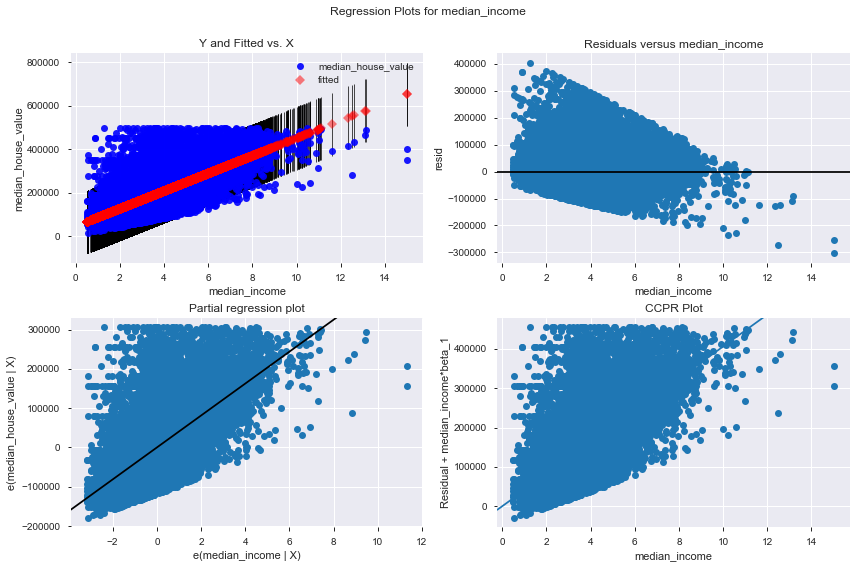

In [13]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(houses_areas_1_model, "median_income", fig=fig)

The residuals doesn't look better without the 500001. Now we will introduce the categorical variables

In [14]:
houses_areas_model_a = ols("median_house_value ~ median_income + ocean_proximity", data = houses_areas).fit()
print(houses_areas_model_a.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5919.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:35   Log-Likelihood:            -2.5674e+05
No. Observations:               20337   AIC:                         5.135e+05
Df Residuals:                   20331   BIC:                         5.135e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

The R-square is better and the AIC and BIC are lower, and the p value look fine. This probably is a better model, lets check the residuals.

In [15]:
houses_areas__1_model_a = ols("median_house_value ~ median_income + ocean_proximity", data = houses_areas_1).fit()
print(houses_areas__1_model_a.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     4922.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:35   Log-Likelihood:            -2.4215e+05
No. Observations:               19377   AIC:                         4.843e+05
Df Residuals:                   19371   BIC:                         4.844e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

This model is better if we base our conclutions in the value of AIC and BIC, they went down a lot even with more variables. 

In [16]:
houses_areas_model_b = ols("median_house_value ~ longitude + latitude + housing_median_age + total_rooms + total_bedrooms + population + households + median_income + ocean_proximity", data = houses_areas).fit()
print(houses_areas_model_b.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.657
Method:                 Least Squares   F-statistic:                     3253.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:35   Log-Likelihood:            -2.5498e+05
No. Observations:               20337   AIC:                         5.100e+05
Df Residuals:                   20324   BIC:                         5.101e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

The R-squared looks better but the increase with all the variables is 0.658 and the AIC and BIC values continue went down so this model could work. The main problem is the p value continue to be acceptable. Let's check the same model withot 500001

In [17]:
houses_areas_1_model_b = ols("median_house_value ~ longitude + latitude + housing_median_age + total_rooms + total_bedrooms + population + households + median_income + ocean_proximity", data = houses_areas_1).fit()
print(houses_areas_1_model_b.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     2694.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:35   Log-Likelihood:            -2.4058e+05
No. Observations:               19377   AIC:                         4.812e+05
Df Residuals:                   19364   BIC:                         4.813e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [18]:
houses_areas_model_b = ols("median_house_value ~ median_income + ocean_proximity + housing_median_age", data = houses_areas).fit()
print(houses_areas_model_b.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     5137.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:36   Log-Likelihood:            -2.5649e+05
No. Observations:               20337   AIC:                         5.130e+05
Df Residuals:                   20330   BIC:                         5.131e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

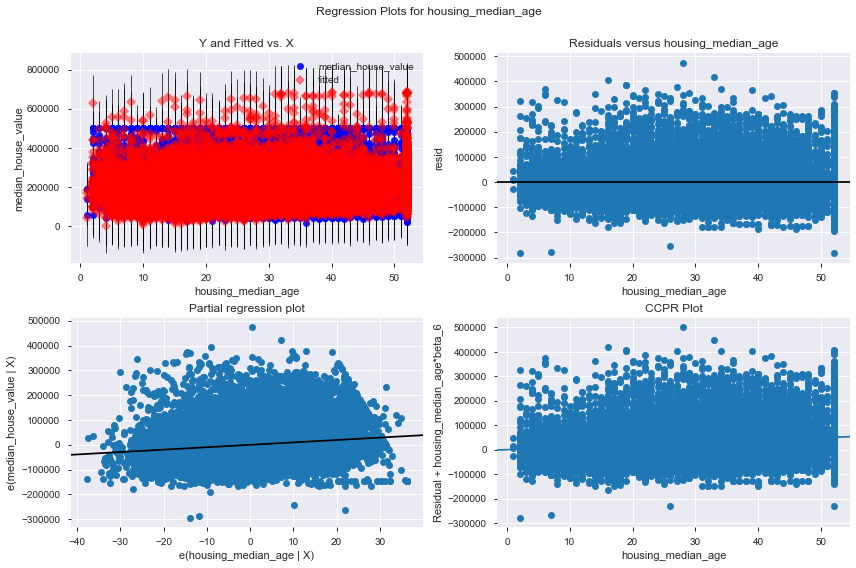

In [19]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(houses_areas_model_b, "housing_median_age", fig=fig)

The residuals looks better with housing_median_age incorporate, so we shold continue use this variable 

In [20]:
houses_areas_1_model_b = ols("median_house_value ~ median_income + ocean_proximity + housing_median_age", data = houses_areas_1).fit()
print(houses_areas_1_model_b.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     4257.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:39   Log-Likelihood:            -2.4195e+05
No. Observations:               19377   AIC:                         4.839e+05
Df Residuals:                   19370   BIC:                         4.840e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

To be honest the model without 500001 doesn't performance better so we wil continue try our model with all the data set

In [21]:
houses_areas_model_c = ols("median_house_value ~ median_income + ocean_proximity + housing_median_age + total_rooms", data = houses_areas).fit()
print(houses_areas_model_c.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     4460.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:39   Log-Likelihood:            -2.5642e+05
No. Observations:               20337   AIC:                         5.128e+05
Df Residuals:                   20329   BIC:                         5.129e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

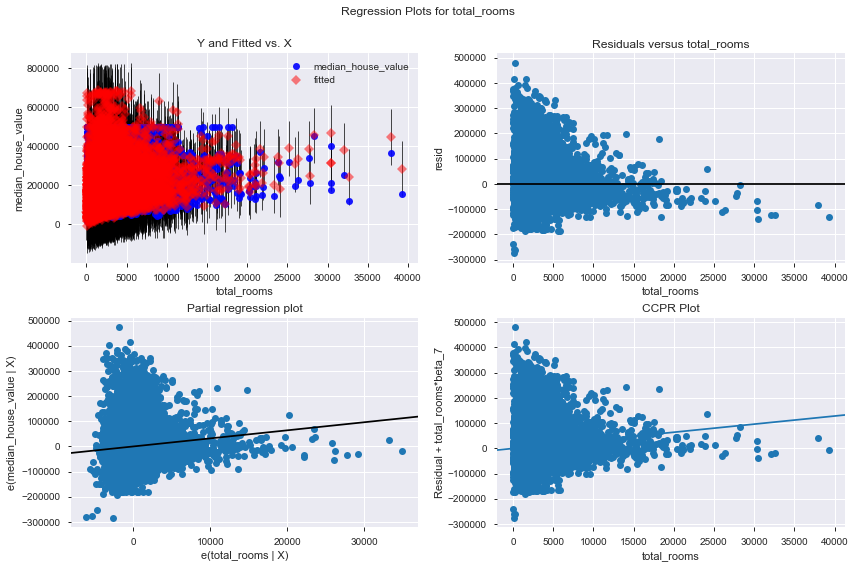

In [22]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(houses_areas_model_c, "total_rooms", fig=fig)

The residials doesn't look very goos with the total_rooms 

In [23]:
houses_areas_model_d = ols("median_house_value ~ median_income + ocean_proximity + housing_median_age + total_rooms + households", data = houses_areas).fit()
print(houses_areas_model_d.summary())

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     3997.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:08:42   Log-Likelihood:            -2.5627e+05
No. Observations:               20337   AIC:                         5.126e+05
Df Residuals:                   20328   BIC:                         5.126e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

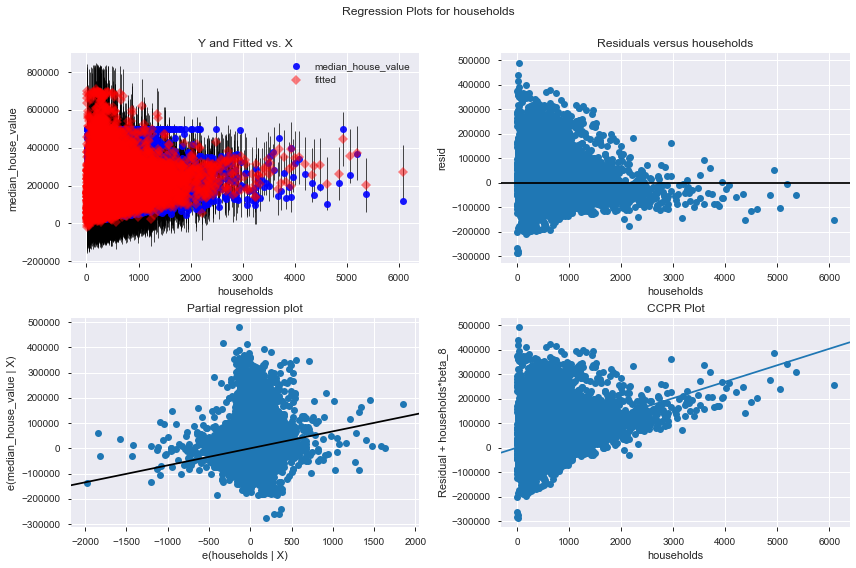

In [24]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(houses_areas_model_d, "households", fig=fig)

The residual doesn't look very good with the households 

After trying different models, we can now have some conclusions:
* The models I created with the removal of houses valued at 500,001 USD behave worst in relation to A-R_Square, but the BIC and AIC look better, as do the residuals. 
* The models that included all variables in data behaved better with respect to all the statistical parameters, for instance the A-R-square is high and both the AIC and BIC are lower; however, the main problem with these models is that they come with noise and overfit the model. 
* The model with houses value at 500,001 USD included and with median_income + ocean_proximity + housing_median_age (MODEL_C) behaves very well. The residuals with respect to housing_median_age look well spread and the A-R-square is higher, whilst the AIC and BIC are lower. These values are better in the model containing all the variables, but here (with only 3 variable) we can be sure that we are not introducing noise and that we prevent overfitting.

Therefore, my recommendation is to use Model_C to predict the median house value in a particular area.